# **Pengembangan Model Klasifikasi Gambar untuk Klasifikasi Multiclass Project "RasaNusa" Menggunakan Arsitektur TensorFlow dan MobileNetV2**

Proyek ini mengembangkan dan mengimplementasikan model deep learning untuk klasifikasi gambar multiclass menggunakan arsitektur TensorFlow dan MobileNetV2. Dengan memanfaatkan teknik augmentasi data, transfer learning, serta evaluasi performa model.

**<h3>1. Import Package**

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from IPython.display import display, clear_output
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import drive
import ipywidgets as widgets
import tensorflow as tf
from PIL import Image
import numpy as np
import io
import os

**<h3>2. Mount Google Drive**

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


**<h3>3. Direktori Dataset**

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/capstone_project/capstone_project/data/train'
VALIDATION_DIR = '/content/drive/MyDrive/capstone_project/capstone_project/data/valid'
TEST_DIR = '/content/drive/MyDrive/capstone_project/capstone_project/data/test'

## **4. Konfigurasi Data dan Augmentasi**

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentasi dan pemrosesan dataset
def train_val_datasets():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        channel_shift_range=20.0
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_dataset = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    validation_dataset = val_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_dataset, validation_dataset

train_dataset, validation_dataset = train_val_datasets()

Found 506 images belonging to 11 classes.
Found 83 images belonging to 11 classes.


**<h3>5. Create Model**

In [5]:
def create_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(len(train_dataset.class_indices), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    return model

classification_model = create_model()
classification_model.summary()

history_model = classification_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,620,235 (10.00 MB)

 Trainable params: 2,217,355 (8.46 MB)

 Non-trainable params: 402,880 (1.54 MB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 210s 7s/step - accuracy: 0.1191 - loss: 3.2106 - val_accuracy: 0.2169 - val_loss: 2.8603 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step - accuracy: 0.2796 - loss: 2.7008 - val_accuracy: 0.3976 - val_loss: 2.6274 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.4226 - loss: 2.4108 - val_accuracy: 0.5060 - val_loss: 2.3592 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.5788 - loss: 2.0745 - val_accuracy: 0.6145 - val_loss: 2.0433 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.6807 - loss: 1.7585 - val_accuracy: 0.6988 - val_loss: 1.7429 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step - accuracy: 0.7552 - loss: 1.4411 - val_accuracy: 0.7590 - val_loss: 1.5361 - learning_rate: 1.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.8443

**<h3>6. Plot Training**

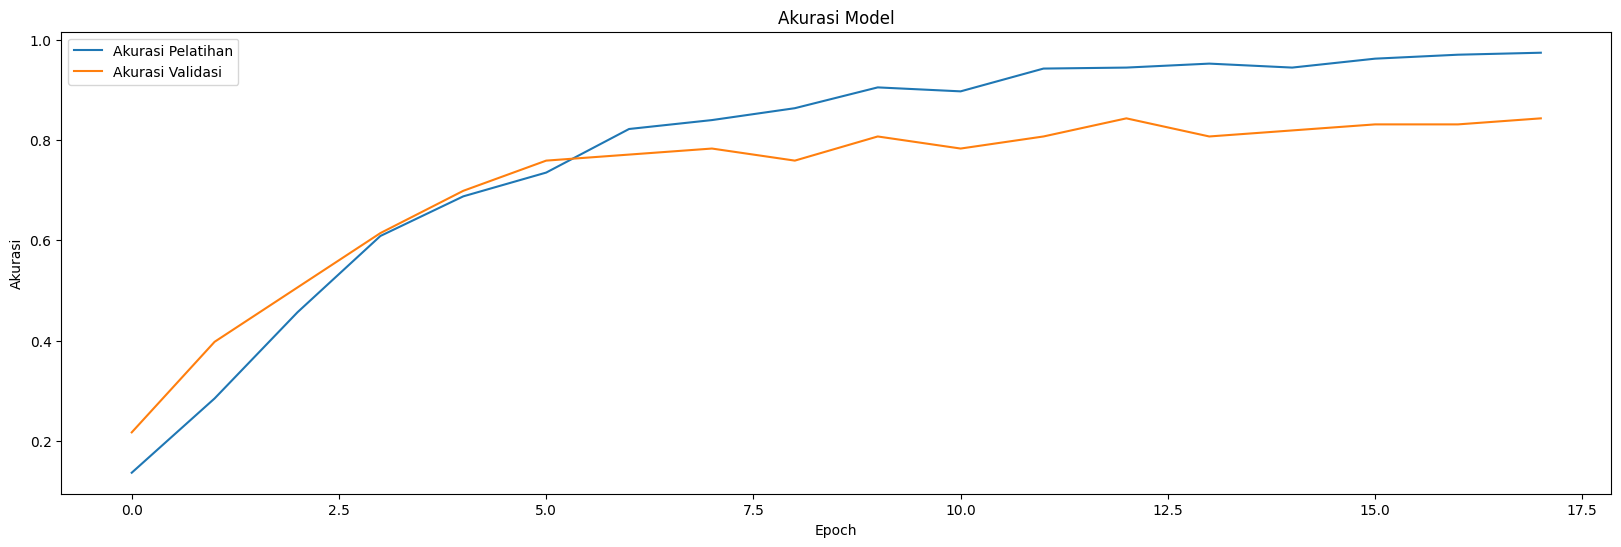

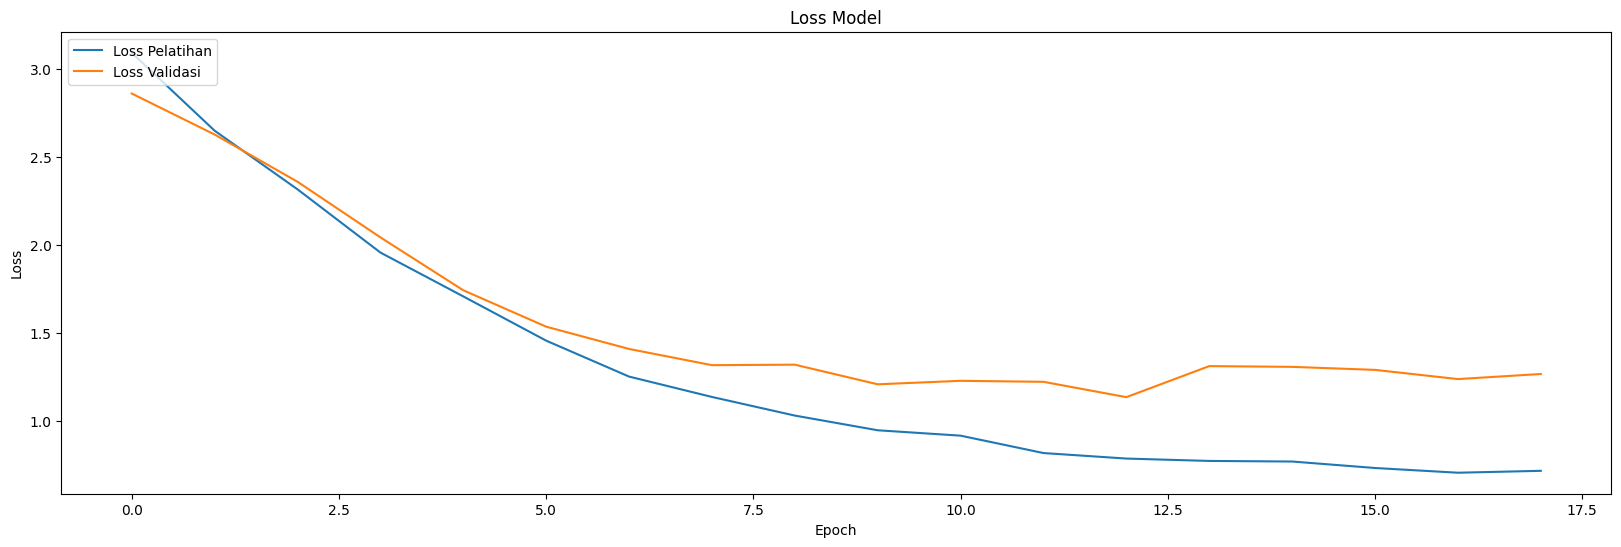

In [6]:
plt.figure(figsize=(20, 6))
plt.plot(history_model.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history_model.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(history_model.history['loss'], label='Loss Pelatihan')
plt.plot(history_model.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

def load_and_preprocess_image(uploaded_image):
    img = Image.open(io.BytesIO(uploaded_image['content']))
    img = img.convert('RGB')
    img = img.resize(IMAGE_SIZE)
    img = np.array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_from_test_folder(test_folder_path, model):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_folder_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False
    )

    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_class_indices = np.argmax(predictions, axis=1)
    class_labels = list(test_generator.class_indices.keys())
    predicted_class_names = [class_labels[i] for i in predicted_class_indices]

    for filename, class_name in zip(test_generator.filenames, predicted_class_names):
        print(f'File: {filename} -> Predicted Class: {class_name}')

**<h3>7. Save Model**

In [7]:
classification_model.save('/content/drive/MyDrive/capstone_project/capstone_project/save_model/classification_model.keras')


**<h3>8. Load Model**

In [8]:
classification_model = load_model('/content/drive/MyDrive/capstone_project/capstone_project/save_model/classification_model.keras')

**<h3>9. Fungsi Uploader**

In [13]:
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def predict_image_with_threshold(uploader, model, threshold=0.6):
    if uploader.value:
        uploaded_image = list(uploader.value.values())[0]
        image = load_and_preprocess_image(uploaded_image)
        predictions = model.predict(image)
        max_prediction_confidence = np.max(predictions)

        if max_prediction_confidence < threshold:
            print("Data tidak tersedia di dataset")
        else:
            predicted_class = np.argmax(predictions, axis=1)
            class_labels = list(train_dataset.class_indices.keys())
            predicted_class_name = class_labels[predicted_class[0]]
            print(f"Predicted Class: {predicted_class_name} with confidence {max_prediction_confidence:.2f}")

predict_button = widgets.Button(description="Predict Image")
predict_button.on_click(lambda x: predict_image_with_threshold(uploader, classification_model))

# Display the button
display(predict_button)


FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Predict Image', style=ButtonStyle())